In [1]:
import numpy as np
import matplotlib.pyplot as plt
from numba import njit
from matplotlib import colors
from IPython import display
import time
from scipy.signal import convolve2d
import os

import functionsAndClasses as fc

In [130]:
from PIL import Image, ImageDraw, ImageFont, ImageOps

im=Image.open("Ratio of dissatisfied agents over time (0.2, 0.9, 8over8).png")

f = ImageFont.truetype("arial.ttf", 15)
txt=Image.new('L', (50,30))
d = ImageDraw.Draw(txt)
d.text( (0, 0), "Energy",  font=f, fill=255)
w=txt.rotate(90,  expand=1)

im.paste( ImageOps.colorize(w, (0,0,0), (0,0,0)), (20,200),  w)
im.show()

In [144]:
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image, ImageDraw, ImageFont

# Abrindo a imagem salva
agentDensityArray = [0.2, 0.35, 0.5, 0.65, 0.8]
residentRelativeDensity = 0.9
merchantsInferiorArray = np.arange(1,9, dtype = float)

for agentDensity in agentDensityArray:
    for merchantsInferior in merchantsInferiorArray:
        plotName = 'Ratio of dissatisfied agents over time (' + str(agentDensity) + ', ' + str(residentRelativeDensity) + ', ' + str(int(np.round(merchantsInferior))) + 'over8)' 
        img = Image.open('steps/' + plotName + '.png')
        
        # Adicionando título e rótulos dos eixos usando PIL
        draw = ImageDraw.Draw(img)
        fontTitle = ImageFont.truetype("arial.ttf", 18)
        fontAxis = ImageFont.truetype("arial.ttf", 15)
        
        # Definindo novos rótulos
        new_title = 'Energy over time (' + str(agentDensity) + ', ' + str(residentRelativeDensity) + ', ' + str(int(np.round(merchantsInferior))) + '/8)'
        new_xlabel = 'Time steps'
        new_ylabel = 'Energy'
        
        # Definindo as coordenadas e dimensões do retângulo
        title_rectangle_coords = [(0, 0), (1000, 55)]  # (x0, y0), (x1, y1)
        xaxix_rectangle_coords = [(0,450), (1000,470)]
        yaxix_rectangle_coords = [(0,0), (40,800)]
        
        # Desenhando o retângulo branco
        draw.rectangle(title_rectangle_coords, fill='white')
        draw.rectangle(xaxix_rectangle_coords, fill='white')
        draw.rectangle(yaxix_rectangle_coords, fill='white')
        
        txt=Image.new('L', (50,30))
        d = ImageDraw.Draw(txt)
        d.text( (0, 0), new_ylabel,  font=fontAxis, fill=255)
        w=txt.rotate(90,  expand=1)
        
        img.paste( ImageOps.colorize(w, (0,0,0), (0,0,0)), (15,215),  w)
        
        # Coordenadas para posicionar o texto
        title_position = (img.width // 2 - len(new_title) * 4, 32)
        xlabel_position = (img.width // 2 - len(new_xlabel) * 5, img.height - 27)
        ylabel_position = (40, img.height // 2 - len(new_ylabel) * 5)
        
        # Escrevendo o texto na imagem
        draw.text(title_position, new_title, fill='black', font=fontTitle)
        draw.text(xlabel_position, new_xlabel, fill='black', font=fontAxis)
        
        # Mostrando a imagem com as alterações
        img.save('steps/Energy over time (' + str(agentDensity) + ', ' + str(residentRelativeDensity) + ', ' + str(int(np.round(merchantsInferior))) + 'over8).png')


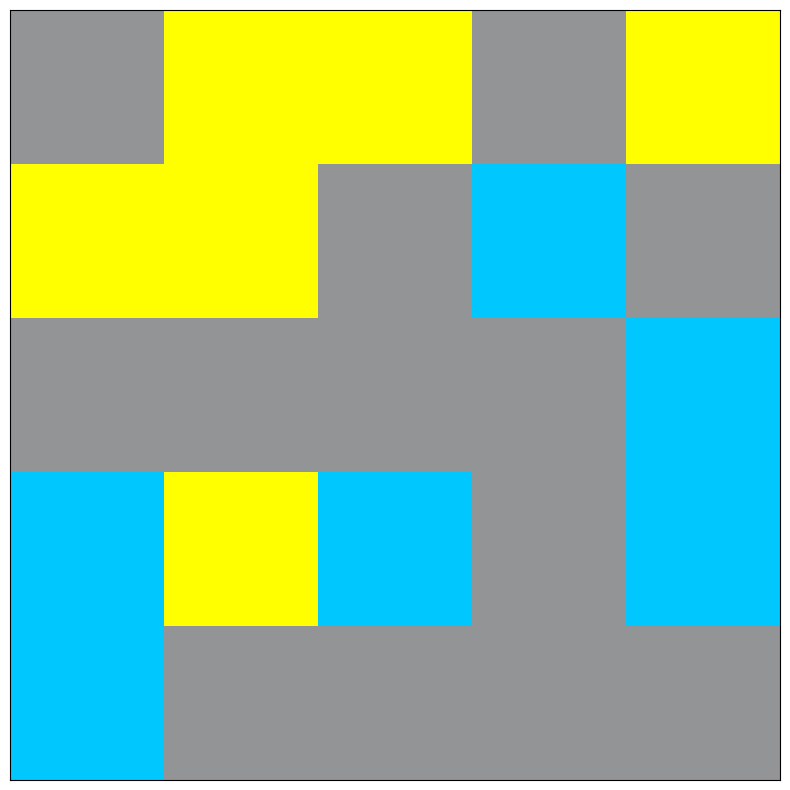

[[5 4 3 3 3]
 [4 3 4 3 4]
 [6 5 4 4 4]
 [4 3 1 3 3]
 [5 6 4 4 4]]
[[0 4 3 0 3]
 [4 3 0 0 0]
 [0 0 0 0 0]
 [0 3 0 0 0]
 [0 0 0 0 0]]
[[0 0 0 0 0]
 [0 0 0 3 0]
 [0 0 0 0 4]
 [4 0 1 0 3]
 [5 0 0 0 0]]
[[0.   1.   0.75 0.   0.75]
 [1.   0.75 0.   0.   0.  ]
 [0.   0.   0.   0.   0.  ]
 [0.   0.75 0.   0.   0.  ]
 [0.   0.   0.   0.   0.  ]]
[[0.    0.    0.    0.    0.   ]
 [0.    0.    0.    0.375 0.   ]
 [0.    0.    0.    0.    0.5  ]
 [0.5   0.    0.125 0.    0.375]
 [0.625 0.    0.    0.    0.   ]]
[[0.10301243 0.51639463 0.98316956 0.55210715 0.75853958]
 [0.84334177 0.47214207 0.18237748 0.73885664 0.38954025]
 [0.22595194 0.42314338 0.14969829 0.65072002 0.09912862]
 [0.09706477 0.48524082 0.58651074 0.40659919 0.57556618]
 [0.46576288 0.44699981 0.07281074 0.40107486 0.59001988]]
[[False False  True False  True]
 [False False False False False]
 [False False False False False]
 [False False False False False]
 [False False False False False]]
[[False False False False False]
 [Fal

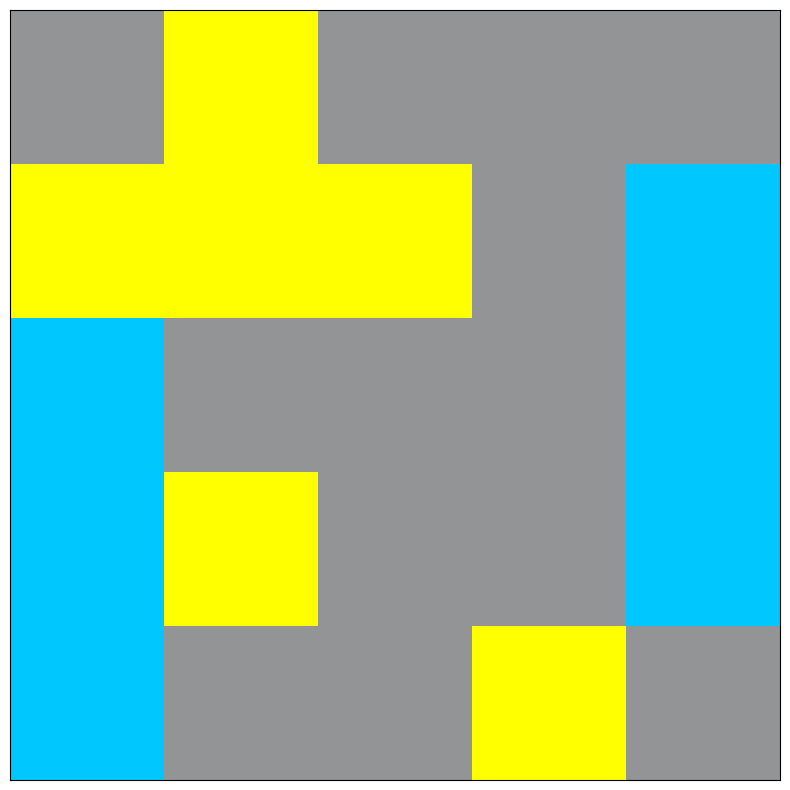

In [5]:
# city properties
L = 5
agentDensity = 0.5
residentRelativeDensity = 0.5
periodicBoundaries = True

# neighborhood size
neighborhood = 1
kernel_side = (2*neighborhood+1)
max_neighbors = kernel_side**2 - 1


# simulation properties
timeSteps = 10000
unitaryEvolution = False
plot = False
plotInterval = 10
plotEnd = True
imagesInGif = 30

args = [('neighborhood', neighborhood),
        ('periodicBoundaries', periodicBoundaries)]

city = fc.City_Continuous(L, agentDensity, residentRelativeDensity)
city.change_properties(args)
city.print_city()
city.evolve(1)
city.print_city()

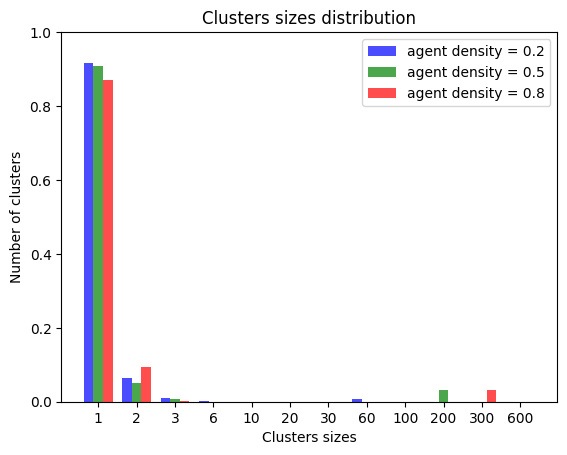

In [54]:
import numpy as np
import matplotlib.pyplot as plt
import ast

# Função para converter os dados de string para uma lista de números
def parse_data(data):
    return ast.literal_eval(data)

# Dados para três simulações diferentes
with open('data(0.2,0.8).txt', 'r') as file1:
    data1 = parse_data(file1.read())

with open('data(0.5,0.8).txt', 'r') as file2:
    data2 = parse_data(file2.read())

with open('data(0.8,0.8).txt', 'r') as file3:
    data3 = parse_data(file3.read())

# Limites dos bins fornecidos
bins_proposta = [1, 2, 3, 6, 10, 20, 30, 60, 100, 200, 300, 600, 1000]

# Calculando os pontos no eixo x
x_positions = np.arange(len(bins_proposta))

# Criando o plot vazio
fig, ax = plt.subplots()

# Adicionando os pontos destacados no eixo x
ax.set_xticks(x_positions)
ax.set_ylim(0, 1)

# Modificando os rótulos do eixo x para corresponder aos limites dos bins
ax.set_xticklabels(bins_proposta)

# Adicionando título ao eixo x
plt.xlabel('Cluster Sizes')

# Calculando os histogramas manualmente
hist_values1, _ = np.histogram(data1, bins=bins_proposta)
hist_values2, _ = np.histogram(data2, bins=bins_proposta)
hist_values3, _ = np.histogram(data3, bins=bins_proposta)

bar_width = 0.25
x_offset = -bar_width

for hist_values, color in zip([hist_values1, hist_values2, hist_values3], ['blue', 'green', 'red']):
    denominator = 0
    for value in hist_values:
        denominator += value

    mape = {'blue': 2, 'green': 5, 'red': 8}
    plt.bar(x_positions[:-1] + x_offset, hist_values/denominator, width=bar_width, color=color, alpha=0.7, label = 'agent density = 0.' + str(mape[color]))
    x_offset += bar_width

plt.title('Clusters sizes distribution')
plt.xlabel('Clusters sizes')
plt.ylabel('Number of clusters')
plt.legend()

# Exibindo o plot
plt.show()

In [80]:
L = 50
agentDensity = 0.2
minimalNumberOfNeighbors = 5
residentRelativeDensity = 0
timeSteps = 10000
periodicBoundaries = False
unitaryEvolution = False
plot = True
args = [('neighborhood', 1), ('minimal_neighbors_merchant_density', minimalNumberOfNeighbors/8), ('minimal_merchant_neighbors_resident_density', 0)]

city = fc.City(L, agentDensity, residentRelativeDensity)
city.change_properties(args)

if unitaryEvolution:
    for i in range(timeSteps * 1000):
        city.evolve_unitary(periodicBoundaries, 1)
    
        if i%50 == 0 and plot:
            city.print_city()
            display.clear_output(wait=True)

    display.clear_output(wait=True)
    city.print_city()


else:
    for i in range(timeSteps):
        # stop condition
        if i%5 == 0:
            oldCity = np.copy(city.city)
            city.evolve(periodicBoundaries, 1)
            dif = oldCity - city.city
            if all(all(element == 0) for element in dif):
                city.print_city()
                break

        else:
            city.evolve(periodicBoundaries, 1)

        if i%100 == 0 and plot:
            city.print_city()
            display.clear_output(wait=True)

    display.clear_output(wait=True)
    city.print_city()

KeyboardInterrupt: 

In [74]:
a = 8/8.0
print(a)

1.0


In [14]:
def resident_satisfaction_function(num_neighs):
    satisfaction = 1 - abs(1 - (2.0*num_neighs)/8) 

    return satisfaction

def merchant_satisfaction_function(num_neighs):
    satisfaction = num_neighs/8.0

    return satisfaction



[[0. 0. 0.]
 [1. 0. 0.]
 [0. 1. 0.]]
[[0.  0.5 0. ]
 [0.  0.5 0.5]
 [0.  0.  0. ]]
[[0.05838942 0.62765113 0.71349534]
 [0.23478083 0.42788838 0.25797481]
 [0.12562179 0.32989208 0.80822103]]


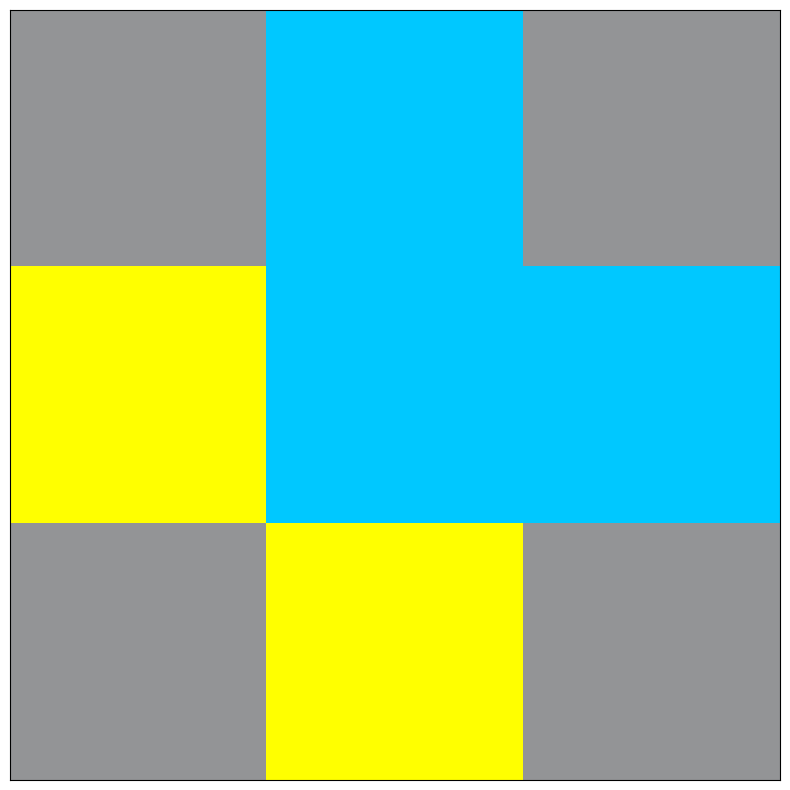

[[False False False]
 [False False False]
 [False False False]]
[[False  True False]
 [False False False]
 [False False False]]


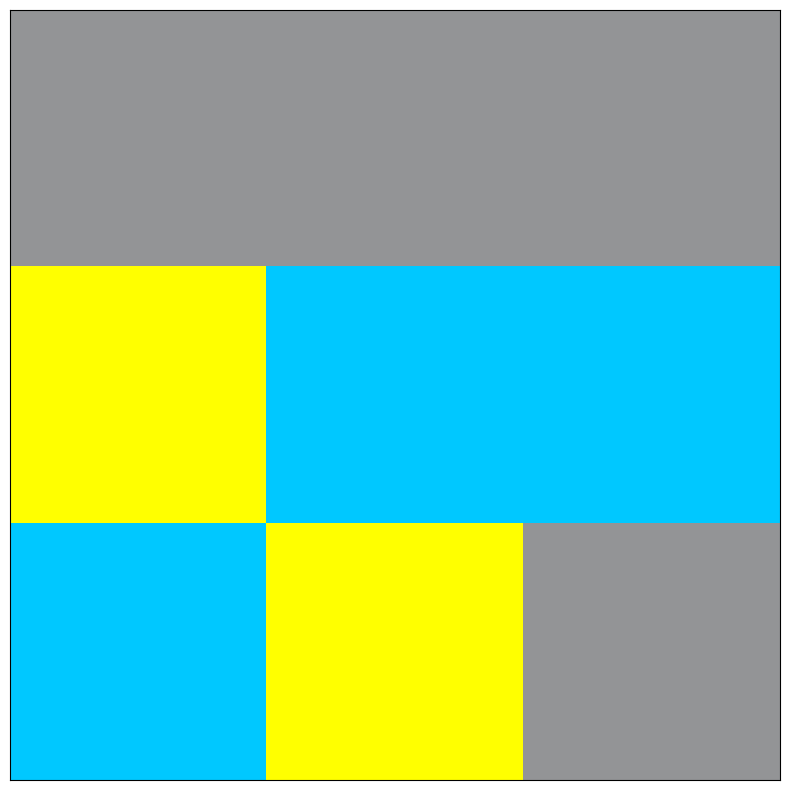

In [64]:
matrix = np.array([[0,-1,0],
                   [1,-1,-1],
                   [0,1,0]])
city = fc.City(matrix)

boundary = 'wrap'
kernel_side = 3
KERNEL = np.ones((kernel_side, kernel_side), dtype=np.int8)
middle = int(kernel_side/2)
KERNEL[middle][middle] = 0
kws = dict(mode='same', boundary=boundary)
Neighs = convolve2d(city.city != 0,  KERNEL, **kws)
Neighs_of_residents = (city.city == 1) * Neighs
Neighs_of_merchants = (city.city == -1) * Neighs
Neighs_of_residents = (city.city == 1) * Neighs
Neighs_of_merchants = (city.city == -1) * Neighs
residents_satisfaction = resident_satisfaction_function(Neighs_of_residents)
merchants_satisfaction = merchant_satisfaction_function(Neighs_of_merchants)
randomMatrix = np.random.rand(L,L)
print(residents_satisfaction)
print(merchants_satisfaction)
print(randomMatrix)
city.print_city()

# conditions of dissatisfaction
Resident_dissatisfied = ((residents_satisfaction <= randomMatrix) &  # agent satisfaction is 1 - probability to move
                       (city.city == 1))

Merchant_dissatisfied = ((merchants_satisfaction <= randomMatrix) &  # agent satisfaction is 1 - probability to move
                       (city.city == -1))

print(Resident_dissatisfied)
print(Merchant_dissatisfied)
city.city[Resident_dissatisfied | Merchant_dissatisfied] = 0
vacant = (city.city == 0).sum()

N_Resident_dissatisfied, N_Merchant_dissatisfied = Resident_dissatisfied.sum(), Merchant_dissatisfied.sum()
filling = np.full(vacant, 0, dtype=np.int8)
filling[:N_Resident_dissatisfied] = 1
filling[N_Resident_dissatisfied:N_Resident_dissatisfied + N_Merchant_dissatisfied] = -1
np.random.shuffle(filling)
city.city[city.city == 0] = filling

city.print_city()

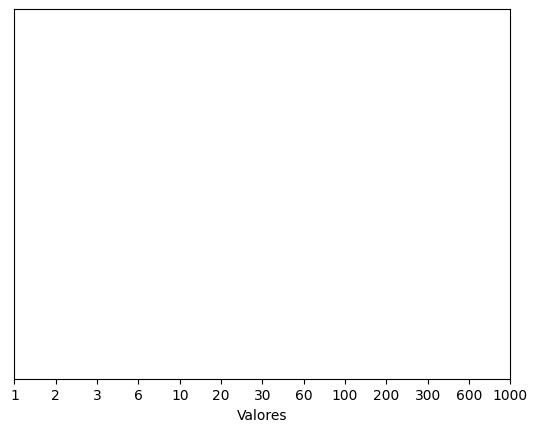

In [6]:
# Limites dos bins fornecidos
bins_proposta = [1, 2, 3, 6, 10, 20, 30, 60, 100, 200, 300, 600, 1000]

# Calculando a transformação logarítmica dos limites dos bins
log_bins = np.log10(bins_proposta)

# Calculando os pontos no eixo x
x_positions = np.arange(len(bins_proposta))

# Criando o plot vazio
fig, ax = plt.subplots()

# Adicionando os pontos destacados no eixo x
ax.set_xticks(x_positions)
# Modificando os rótulos do eixo x para corresponder aos limites dos bins
ax.set_xticklabels(bins_proposta)

# Ocultando a barra de eixo y (pois não estamos plotando nada lá)
plt.gca().axes.get_yaxis().set_visible(False)

# Adicionando título ao eixo x
plt.xlabel('Valores')

# Exibindo o plot
plt.show()

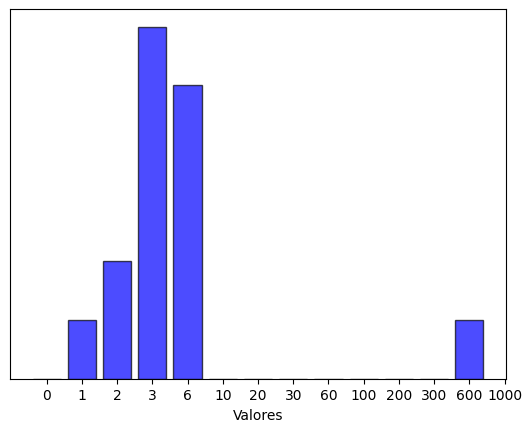

In [30]:
# Dados de exemplo
data = [1, 2, 2, 3, 3, 3, 4, 4, 5, 6, 7, 8, 8, 9, 999]

# Limites dos bins fornecidos
bins_proposta = [0, 1, 2, 3, 6, 10, 20, 30, 60, 100, 200, 300, 600, 1000]

# Calculando os pontos no eixo x
x_positions = np.arange(len(bins_proposta))

# Criando o plot vazio
fig, ax = plt.subplots()

# Adicionando os pontos destacados no eixo x
ax.set_xticks(x_positions)
# Modificando os rótulos do eixo x para corresponder aos limites dos bins
ax.set_xticklabels(bins_proposta)

# Ocultando a barra de eixo y (pois não estamos plotando nada lá)
plt.gca().axes.get_yaxis().set_visible(False)

# Adicionando título ao eixo x
plt.xlabel('Valores')

# Criando o histograma manualmente
hist_values, _ = np.histogram(data, bins=bins_proposta)

plt.bar(x_positions[:-1], hist_values, width=0.8, color='blue', edgecolor='black', alpha=0.7)

# Exibindo o plot
plt.show()

In [3]:
from scipy.signal import convolve2d
import numpy as np

In [13]:
neighborhood = 1
kernel_side = (2*neighborhood+1)
KERNEL = np.ones((kernel_side, kernel_side), dtype=np.int8)
middle = int(kernel_side/2)
KERNEL[middle][middle] = 0

def evolve(M, boundary='fill'):
    kws = dict(mode='same', boundary=boundary)
    Resident_neighs = convolve2d(M == 0,  KERNEL, **kws)
    return Resident_neighs

In [14]:
M = np.array([[1,0,1],
              [-1,-1,0],
              [1,-1,1]])
r = evolve(M)
print(r)

[[1 1 2]
 [1 2 1]
 [0 1 1]]


In [2]:
a = 2

if a == 0:
    print('zero')

elif a == 1:
    print('um')

elif a == 2:
    print('dois')

#print('de 0 a 2')

else:
    print('maior que dois')

dois


In [8]:
args = [('minimal_neighbors_merchant_density', 5/8), ('minimal_merchant_neighbors_resident_density', 1)]

def func(args):
    print(args)
    for arg in args:
        print(arg)

func(args)

[('minimal_neighbors_merchant_density', 0.625), ('minimal_merchant_neighbors_resident_density', 1)]
('minimal_neighbors_merchant_density', 0.625)
('minimal_merchant_neighbors_resident_density', 1)


In [10]:
import numpy as np
import matplotlib.pyplot as plt
from numba import njit
from matplotlib import colors
from IPython import display
import time
from scipy.signal import convolve2d
import os

import functionsAndClasses as fc

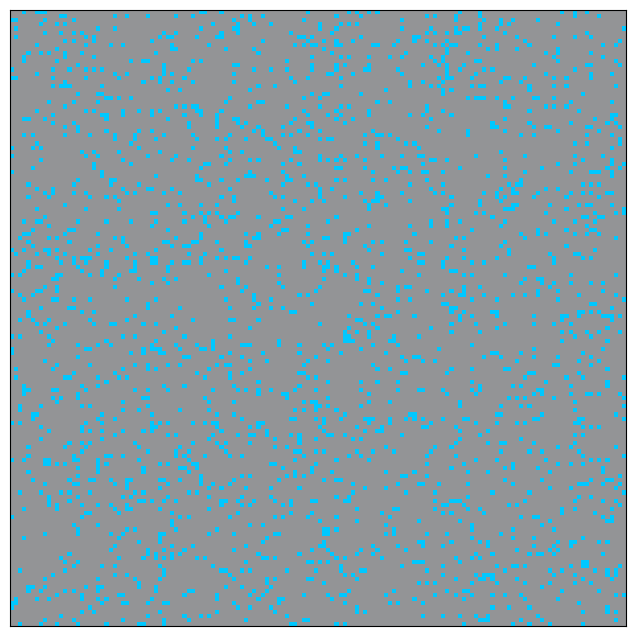

In [12]:
L = 150
agentDensity = 0.1
number = 0
residentRelativeDensity = 0
timeSteps = 10000
periodicBoundaries = True
unitaryEvolution = False
plot = True
args = [('neighborhood', 1), ('minimal_neighbors_merchant_density', number/8), ('minimal_merchant_neighbors_resident_density', 0)]

city = fc.City(L, agentDensity, residentRelativeDensity)
city.change_properties(args)

if unitaryEvolution:
    for i in range(timeSteps * 1000):
        city.evolve_unitary(periodicBoundaries, 1)
    
        if i%50 == 0 and plot:
            city.print_city()
            display.clear_output(wait=True)

    display.clear_output(wait=True)
    city.print_city()


else:
    for i in range(timeSteps):
        # stop condition
        if i%5 == 0:
            oldCity = np.copy(city.city)
            city.evolve(periodicBoundaries, 1)
            dif = oldCity - city.city
            if all(all(element == 0) for element in dif):
                city.print_city()
                break

        else:
            city.evolve(periodicBoundaries, 1)

        if i%200 == 0 and plot:
            city.print_city()
            display.clear_output(wait=True)

    display.clear_output(wait=True)
    city.print_city()

In [1]:
20/21 == 1000/1050

True